机器学习总结-回归
===

# 1.使用SKLearn对曲线进行回归

[11:40:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


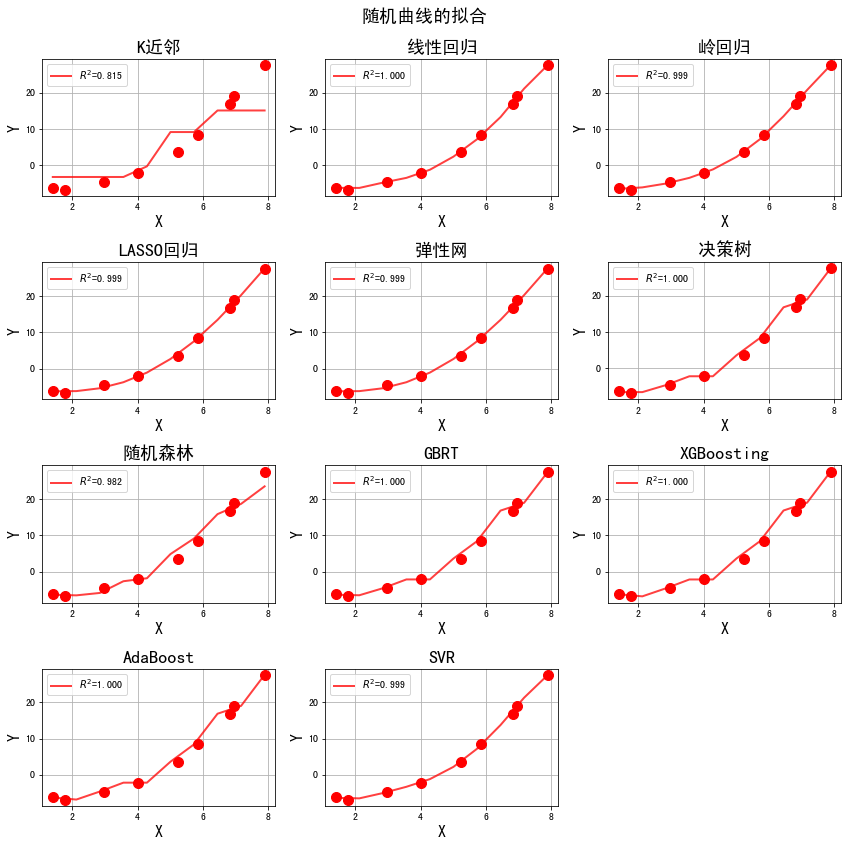

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn import svm
from sklearn import metrics
import xgboost as xgb
import matplotlib as mpl

mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

np.random.seed(0)
np.set_printoptions(linewidth=1000)
N = 9
# x = np.linspace(0, 8, N) + np.random.randn(N)
# x = np.sort(x)
# y = x**2 - 4*x - 3 + np.random.randn(N)
x = np.array([1.40015721,1.76405235,2.97873798,4.02272212,5.2408932,5.86755799,6.84864279,6.95008842,7.89678115])
y = np.array([-6.22959012,-6.80028513,-4.58779845,-2.1475575,3.62506375,8.40186804,16.84301125,18.99745441,27.56686965])

x.shape = -1, 1
y.shape = -1, 1

modelList = [
    [KNeighborsRegressor(), 'K近邻'],
    [Pipeline([('poly', PolynomialFeatures(degree=7)),
               ('linear', LinearRegression(fit_intercept=False))]), '线性回归'],
    [Pipeline([('poly', PolynomialFeatures(degree=5)),
               ('linear', RidgeCV(alphas=np.logspace(-3, 2, 50), fit_intercept=False))]), '岭回归'],
    [Pipeline([('poly', PolynomialFeatures(degree=6)),
               ('linear', LassoCV(alphas=np.logspace(-3, 2, 50), fit_intercept=False))]), 'LASSO回归'],
    [Pipeline([('poly', PolynomialFeatures(degree=6)),
               ('linear', ElasticNetCV(alphas=np.logspace(-3, 2, 50),
                                       l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                                       fit_intercept=False))]), '弹性网'],
    [DecisionTreeRegressor(criterion='mse',max_depth=4), '决策树'],
    [RandomForestRegressor(n_estimators=10, max_depth=3), '随机森林'],
    [GradientBoostingRegressor(n_estimators=100, max_depth=1), 'GBRT'],
    [xgb.XGBRegressor(n_estimators=200, max_depth=4), 'XGBoosting'],
    [AdaBoostRegressor(n_estimators=100), 'AdaBoost'],
    [svm.SVR(kernel='rbf', gamma=0.2, C=100), 'SVR']
]

x_hat = np.linspace(x.min(), x.max(), num=10)
x_hat.shape = -1, 1
plt.figure(figsize=(12, 12), facecolor='w')

for i, clf in enumerate(modelList):
    model = clf[0]
    title = clf[1]
    model.fit(x, y.ravel())
    y_hat = model.predict(x_hat)

    plt.subplot(4, 3, i+1)
    plt.plot(x, y, 'ro', ms=10, zorder=N)

    y_pred = model.predict(x)
    r2 = metrics.r2_score(y, y_pred)

    label = u'$R^2$=%.3f' % (r2)
    plt.plot(x_hat, y_hat, color='r', lw=2, label=label, alpha=0.75)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.title(title, fontsize=18)
    plt.xlabel('X', fontsize=16)
    plt.ylabel('Y', fontsize=16)

plt.suptitle('随机曲线的拟合',fontsize=18)
plt.tight_layout(1.5)
plt.subplots_adjust(top=0.92)

# 2.使用Pytorch对曲线进行拟合

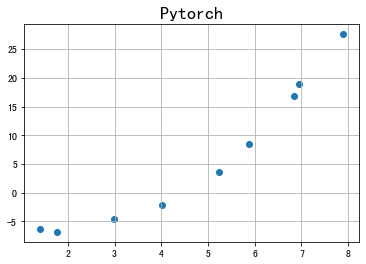

In [3]:
import torch
from torch.nn import Linear, Sequential, ReLU, MSELoss
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.animation as animation

STEPS = 30000
DECAY_STEP = 100
np.random.seed(0)
np.set_printoptions(linewidth=1000)

x = np.array([1.40015721,1.76405235,2.97873798,4.02272212,5.2408932,5.86755799,6.84864279,6.95008842,7.89678115])
y = np.array([-6.22959012,-6.80028513,-4.58779845,-2.1475575,3.62506375,8.40186804,16.84301125,18.99745441,27.56686965])

x_data = torch.FloatTensor(x)
y_data = torch.FloatTensor(y)

x_data = torch.unsqueeze(x_data, dim=1)
y_data = torch.unsqueeze(y_data, dim=1)

Net = Sequential(
    Linear(in_features=1, out_features=10),
    ReLU(inplace=True),
    Linear(in_features=10, out_features=1)
)

optimizer = torch.optim.RMSprop(Net.parameters(), lr=0.0005)
loss_func = MSELoss()

x_data, y_data = Variable(x_data), Variable(y_data)
predict = []
myloss = []

for step in range(STEPS):
    prediction = Net(x_data)
    loss = loss_func(prediction, y_data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step + 1) % DECAY_STEP == 0:
        predict.append(prediction.data.numpy())
        myloss.append(loss.item())

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = ax.plot([], [], 'r-', animated=False)
plt.scatter(x_data, y_data)
plt.grid(True)
time_template = 'step = %d, train loss=%.9f'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
plt.title('Pytorch', fontsize=18)
def init():
    return ln,

def update(i):
    newx = x_data
    newy = predict[i]
    ln.set_data(newx, newy)
    time_text.set_text(time_template % (i * DECAY_STEP, myloss[i]))
    return ln,

# ani = animation.FuncAnimation(fig, update, frames=range(int(STEPS / DECAY_STEP)),
#                               init_func=init, interval=50)
# ani.save("../results/02_13_07.gif", writer='imagemagick', fps=100)
# plt.show()


![Images](../images/14_02_001.gif)

# 3.使用Tensorflow对曲线进行拟合

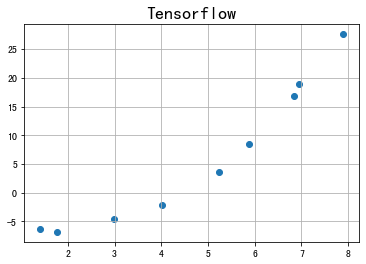

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.animation as animation

STEPS = 30000
DECAY_STEP = 100
N = 9
x_data = np.linspace(0, 8, N)[:, np.newaxis] + np.random.randn(N)[:, np.newaxis]
x_data = np.sort(x_data)
y_data = x_data**2 - 4*x_data - 3 + np.random.randn(N)[:, np.newaxis]

x_data = np.array([1.40015721,1.76405235,2.97873798,4.02272212,5.2408932,5.86755799,6.84864279,6.95008842,7.89678115])[:, np.newaxis]
y_data = np.array([-6.22959012,-6.80028513,-4.58779845,-2.1475575,3.62506375,8.40186804,16.84301125,18.99745441,27.56686965])[:, np.newaxis]


x = tf.placeholder(tf.float32, [None, 1])
y = tf.placeholder(tf.float32, [None, 1])

Weights_L1 = tf.Variable(tf.random_normal([1, 10]))
biases_L1 = tf.Variable(tf.zeros([1,10]))
Wx_plus_b_L1 = tf.matmul(x, Weights_L1) + biases_L1
L1 = tf.nn.relu(Wx_plus_b_L1)

Weights_L2 = tf.Variable(tf.random_normal([10, 1]))
biases_L2 = tf.Variable(tf.zeros([1,1]))
prediction = tf.matmul(L1, Weights_L2) + biases_L2
# prediction = tf.nn.tanh(Wx_plus_b_L2)

loss = tf.reduce_mean(tf.square(y - prediction))
train_step = tf.train.MomentumOptimizer(0.0001, momentum=0.1).minimize(loss)

predict = []
myloss = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(STEPS):
        _, train_loss,prediction_value = sess.run([train_step, loss, prediction], feed_dict={x:x_data, y:y_data})

        if (step + 1) % DECAY_STEP == 0:
            predict.append(prediction_value)
            myloss.append(train_loss)

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = ax.plot([], [], 'r-', animated=False)
plt.scatter(x_data, y_data)
time_template = 'step = %d, train loss=%.9f'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
plt.title('Tensorflow', fontsize=18)
plt.grid(True)
def init():
    return ln,

def update(i):
    newx = x_data
    newy = predict[i]
    ln.set_data(newx, newy)
    time_text.set_text(time_template % (i * DECAY_STEP, myloss[i]))
    return ln,

# ani = animation.FuncAnimation(fig, update, frames=range(int(STEPS / DECAY_STEP)),
#                               init_func=init, interval=50)
# ani.save("../results/02_13_08.gif", writer='imagemagick', fps=100)
# plt.show()

![Images](images/14_02_002.gif)

# 4.使用SKLearn对广告数据进行拟合

[11:49:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


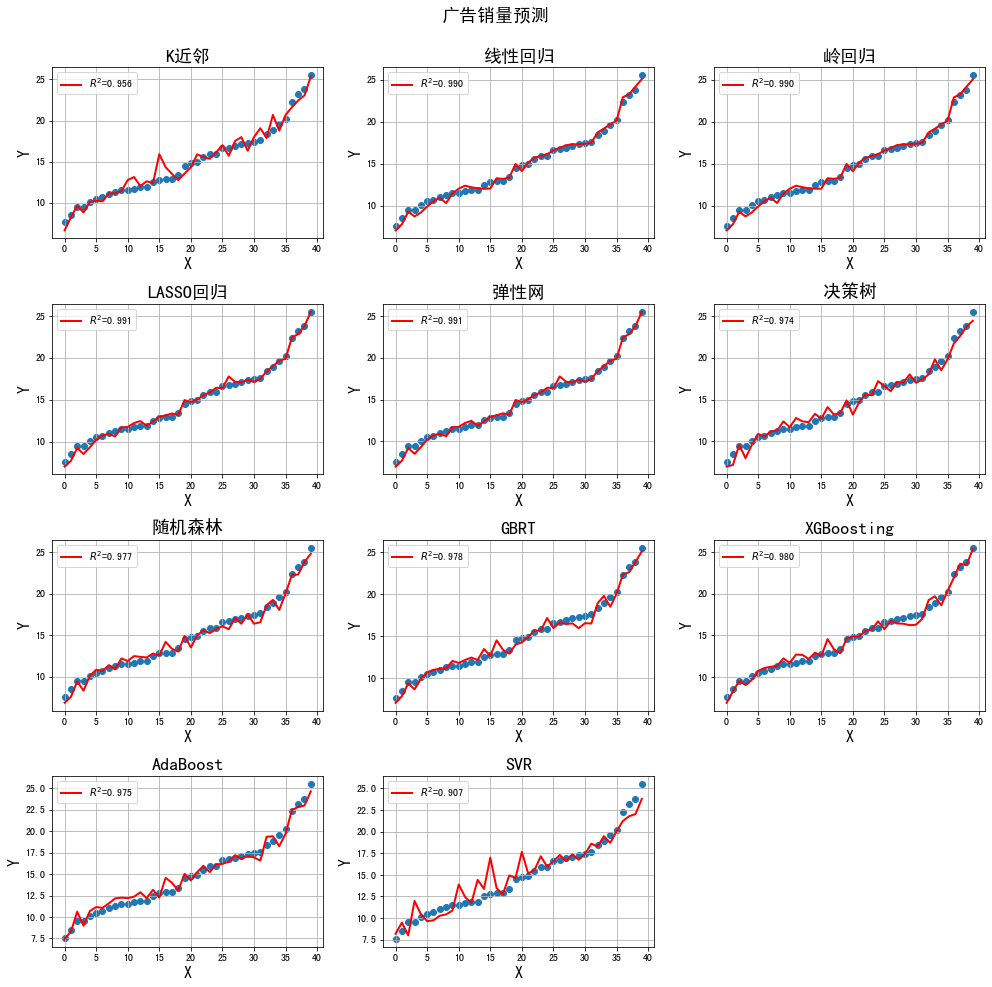

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn import svm
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import os

data_path = os.path.join("data")
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
data = pd.read_csv(os.path.join(data_path, 'Advertising.csv'))
x = data[['TV', 'Radio']]
y = data['Sales']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=1)

modelList = [
    [KNeighborsRegressor(), 'K近邻'],
    [Pipeline([('poly', PolynomialFeatures()),
               ('linear', LinearRegression(fit_intercept=False))]), '线性回归'],
    [Pipeline([('poly', PolynomialFeatures()),
               ('linear', RidgeCV(alphas=np.logspace(-3, 2, 50), fit_intercept=False))]), '岭回归'],
    [Pipeline([('poly', PolynomialFeatures(degree=6)),
               ('linear', LassoCV(alphas=np.logspace(-3, 2, 50), fit_intercept=False))]), 'LASSO回归'],
    [Pipeline([('poly', PolynomialFeatures(degree=6)),
               ('linear', ElasticNetCV(alphas=np.logspace(-3, 2, 50),
                                       l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                                       fit_intercept=False))]), '弹性网'],
    [DecisionTreeRegressor(criterion='mse'), '决策树'],
    [RandomForestRegressor(n_estimators=10), '随机森林'],
    [GradientBoostingRegressor(n_estimators=100), 'GBRT'],
    [xgb.XGBRegressor(n_estimators=200, max_depth=4), 'XGBoosting'],
    [AdaBoostRegressor(n_estimators=100), 'AdaBoost'],
    [svm.SVR(kernel='linear'), 'SVR']
]

plt.figure(figsize=(14, 14 ), facecolor='w')
order = y_test.argsort(axis=0)
x_test = x_test.values[order, :]
y_test = y_test.values[order]
x_test = pd.DataFrame(x_test)
x_test.columns = ['TV', 'Radio']
x_hat = np.arange(len(x_test))
for i, clf in enumerate(modelList):
    model = clf[0]
    title = clf[1]
    model.fit(x_train, y_train)

    y_hat = model.predict(x_test)

    plt.subplot(4, 3, i+1)
    plt.scatter(x_hat, y_test)

    r2 = model.score(x_test, y_test)

    label = u'$R^2$=%.3f' % (r2)
    plt.plot(x_hat, y_hat, 'r-',linewidth=2, label=label)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.title(title, fontsize=18)
    plt.xlabel('X', fontsize=16)
    plt.ylabel('Y', fontsize=16)

plt.suptitle('广告销量预测',fontsize=18)
plt.tight_layout(1.5)
plt.subplots_adjust(top=0.92)

# 5.使用Pytorch对广告数据进行拟合

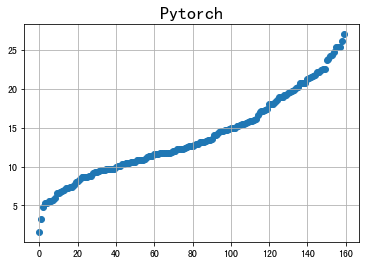

In [7]:
import pandas as pd
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import torch
from torch.nn import Linear, Sequential, ReLU, MSELoss, Sigmoid
import numpy as np
from torch.autograd import Variable
from torch.optim import SGD, Adam, rmsprop
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

data_path = os.path.join("data")
STEPS = 30000
DECAY_STEP = 100

# pandas读入
dataFile = os.path.join(data_path, 'Advertising.csv')
data = pd.read_csv(dataFile)
x = data[['TV', 'Radio']]
y = data['Sales']

mpl.rcParams['font.sans-serif'] = [u'simHei']
mpl.rcParams['axes.unicode_minus'] = False

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=1)


order = y_train.argsort(axis=0)
y_train = y_train.values[order]
y_train = np.reshape(y_train, newshape=(y_train.shape[0], 1))
x_train = x_train.values[order, :]

x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

Net = Sequential(
    # BatchNorm1d(num_features=2),
    Linear(in_features=2, out_features=10),

    ReLU(inplace=True),
    Linear(in_features=10, out_features=1),
)

optimizer = torch.optim.RMSprop(Net.parameters(), lr=0.001)
loss_func = MSELoss()

x_data, y_data = Variable(x_train), Variable(y_train)
predict = []
myloss = []

for step in range(STEPS):
    prediction = Net(x_data)
    loss = loss_func(prediction, y_data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step + 1) % DECAY_STEP == 0:
        predict.append(prediction.data.numpy())
        myloss.append(loss.item())
#
fig, ax = plt.subplots()
t = np.arange(len(x_data))
ln, = ax.plot([], [], 'r-', animated=False)
plt.scatter(t, y_data)
plt.title('Pytorch', fontsize=18)
time_template = 'step = %d, train loss=%.9f'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
plt.grid(True)
def init():
    return ln,

def update(i):
    newx = t
    newy = predict[i]
    ln.set_data(newx, newy)
    time_text.set_text(time_template % (i * DECAY_STEP, myloss[i]))
    return ln,

# ani = animation.FuncAnimation(fig, update, frames=range(int(STEPS / DECAY_STEP)),
#                               init_func=init, interval=50)
# ani.save("../results/02_13_10.gif", writer='imagemagick', fps=100)

![Images](images/14_02_003.gif)

# 6.使用Tensorflow对广告数据进行拟合

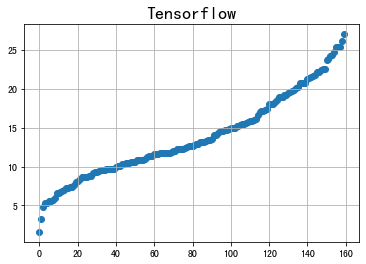

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.animation as animation
import pandas as pd
from sklearn.model_selection import train_test_split
import os

data_path = os.path.join("data")
STEPS = 30000
DECAY_STEP = 100

# pandas读入
dataFile = os.path.join(data_path, 'Advertising.csv')
data = pd.read_csv(dataFile)
x = data[['TV', 'Radio']]
y = data['Sales']

mpl.rcParams['font.sans-serif'] = [u'simHei']
mpl.rcParams['axes.unicode_minus'] = False

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=1)


order = y_train.argsort(axis=0)
y_train = y_train.values[order]
y_train = np.reshape(y_train, newshape=(y_train.shape[0], 1))
x_train = x_train.values[order, :]

x = tf.placeholder(tf.float32, [None, 2])
y = tf.placeholder(tf.float32, [None, 1])

Weights_L1 = tf.Variable(tf.random_normal([2, 10]))
biases_L1 = tf.Variable(tf.zeros([1,10]))
Wx_plus_b_L1 = tf.matmul(x, Weights_L1) + biases_L1
L1 = tf.nn.relu(Wx_plus_b_L1)

Weights_L2 = tf.Variable(tf.random_normal([10, 1]))
biases_L2 = tf.Variable(tf.zeros([1,1]))
prediction = tf.matmul(L1, Weights_L2) + biases_L2
# prediction = tf.nn.tanh(Wx_plus_b_L2)

loss = tf.reduce_mean(tf.square(y - prediction))
train_step = tf.train.AdamOptimizer(0.001).minimize(loss)

predict = []
myloss = []
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for step in range(STEPS):
    _, train_loss,prediction_value = sess.run([train_step, loss, prediction], feed_dict={x:x_train, y:y_train})

    if (step + 1) % DECAY_STEP == 0:
        predict.append(prediction_value)
        myloss.append(train_loss)

fig, ax = plt.subplots()
t = np.arange(len(x_train))
ln, = ax.plot([], [], 'r-', animated=False)
plt.scatter(t, y_train)
time_template = 'step = %d, train loss=%.9f'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
plt.title('Tensorflow', fontsize=18)
plt.grid(True)
def init():
    return ln,

def update(i):
    newx = t
    newy = predict[i]
    ln.set_data(newx, newy)
    time_text.set_text(time_template % (i * DECAY_STEP, myloss[i]))
    return ln,

# ani = animation.FuncAnimation(fig, update, frames=range(int(STEPS / DECAY_STEP)),
#                               init_func=init, interval=50)
# ani.save("../results/02_13_11.gif", writer='imagemagick', fps=100)


![Images](images/14_02_004.gif)